## Deep Evidential Regression (Amini et al., 2020) - Summary

### 1.  Introduction: Why do we need uncertainty estimation in regression?

Neural Networks are increasingly being used in places where mistakes can be dangerous or expensive, such as autonomous driving or medical tasks. 

In these situations, it’s not enough to only receive a prediction. In order to minimize mistakes as much as possible, the model should not only output a prediction, but also say how certain it is about said prediction.

Having reliable uncertainty estimates helps prevent wrong decisions, detect unusual data, and improve the safety of machine learning systems.

### 2. What is Deep Evidential Regression? 

Deep Evidential Regression is a method where a neural network predicts the parameters of a Normal-Inverse-Gamma distribution instead of predicting a single output. 

This higher-order distribution represents “evidence” for the prediction and allows the model to estimate both aleatoric and epistemic uncertainty in one forward pass, without sampling or ensembles.

### 3. Two types of uncertainties in regression models 

**Aleatoric Uncertainty:** noise in the data; it is caused by randomness or measurement noise that even a perfect model can’t eliminate. An example for that would be a noisy sensor reading distance. 

**Epistemic uncertainty:** the model simply doesn’t know enough; it is caused by a lack of knowledge, which decreases with more data. This uncertainty is high when the model sees something unfamiliar or out-of-distribution. An example would be training the model on indoor-only images and then suddenly showing it a snowy mountain. 

These two uncertainties behave differently and matter in different ways, so a good system should be able to estimate both. 

### 4. Proposal of Amini et al. 

The main idea of the paper is to let a neural network predict not only a single output value, but the parameters of a Normal-Inverse-Gamma (NIG) distribution.
This distribution is a higher-order distribution that represents uncertainty about the parameters of a Gaussian likelihood (its mean and variance). By learning this distribution, the model can estimate both aleatoric and epistemic uncertainty in a principled way.

For each regression target, the network outputs four values:

- **γ**: predicted mean
- **υ**: strength of belief about the mean
- **α**: evidence related to the variance
- **β**: scale parameter for the variance

Using these parameters, the model can compute:

- the final prediction
- the aleatoric uncertainty
- the epistemic uncertainty

The key idea is that the NIG distribution captures uncertainty about the likelihood parameters themselves, not just about the data.
This allows the model to express how confident it is about its own prediction without using sampling, dropout, or model ensembles.

Because the model learns how much evidence it has for its predictions, it can increase uncertainty when it makes mistakes or when it sees out-of-distribution data.

### 5. Loss Functions

As explained earlier, in Deep Evidential Regression, the neural network not only outputs a single prediction, but also the parameters of a Normal-Inverse-Gamma distribution. Because of this, the loss function needs to do two things at the same time: make the prediction fit the data + control how much evidence or uncertainty the model produces. 

Because the model outputs a Normal-Inverse-Gamma (NIG) distribution, the resulting likelihood over the target becomes a Student-t distribution. The Student-t distribution is similar to a Gaussian but has heavier tails, which makes it better at handling uncertainty and outliers. This is why the loss function uses the Student-t Negative Log-Likelihood (NLL).

The paper combines two different loss components into one: 

**1. Student-t Negative Log-Likelihood (NLL)**  

This measures how well the predicted distribution matches the true target value.
Because the NIG distribution induces a Student-t likelihood, this term naturally models the data noise and is responsible for learning aleatoric uncertainty.

**2. Evidence Regularizer**  
This penalizes the model when it assigns a large amount of evidence (high confidence) to a prediction that is far from the true value.
It encourages the network to reduce evidence and increase epistemic uncertainty whenever it encounters unfamiliar or difficult inputs.

The total loss is simply:
The final loss combines both parts:

$$
L = L_{\text{NLL}} + \lambda \cdot L_R
$$

where the regularizer is:

$$
L_R = |y - \gamma| \cdot (2\upsilon + \alpha)
$$

This loss encourages the model to make accurate predictions while also expressing meaningful uncertainty.

 

In [37]:
# general imports
import matplotlib.pyplot as plt
import torch
from torch import nn

In [38]:
import torch.nn.functional as F


def evidential_loss(
    y: torch.Tensor,
    gamma: torch.Tensor,
    v: torch.Tensor,
    alpha: torch.Tensor,
    beta: torch.Tensor,
    lam: float = 1.0,
) -> torch.Tensor:
    """Evidential Regression Loss (Amini et al., 2020).

    L = LNLL + λ * LR

    Args:
        y: Ground-truth targets.
        gamma: Predicted mean.
        v: Evidence for the mean (> 0).
        alpha: Evidence for variance (> 1).
        beta: Scale parameter (> 0).
        lam: Regularization weight (λ).
    """
    # Avoid log(0)
    eps = 1e-8

    # --- 1. Student-t Negative Log Likelihood (NLL) ---
    two_bv = 2.0 * beta * (1.0 + v) + eps

    lnll = (
        0.5 * torch.log(torch.pi / (v + eps))
        - alpha * torch.log(two_bv)
        + (alpha + 0.5) * torch.log(v * (y - gamma).pow(2) + two_bv)
        + torch.lgamma(alpha)
        - torch.lgamma(alpha + 0.5)
    )

    # --- 2. Evidence Regularizer (LR) ---
    evidence = 2.0 * v + alpha
    lr = torch.abs(y - gamma) * evidence

    # --- 3. Final Loss ---
    return (lnll + lam * lr).mean()  # return loss

### 6. Comparison with Sensoy et al. (2018)

The Sensoy et al. paper introduces evidential learning for classification using a Dirichlet distribution and a KL-based evidence regularized. Amini et al. extends the evidential idea to regression, using Normal-Inverse-Gamma distribution and a new evidence penalty to capture both aleatoric and epistemic uncertainty. 

Together, these two papers form the foundation of modern evidential deep learning for both classification and regression. 


### 7. Implementation Example (PyTorch)

Below is a minimal PyTorch example (without the unified evidential training function) showing how the Deep Evidential Regression loss can be used to train a simple model on a toy regression dataset.

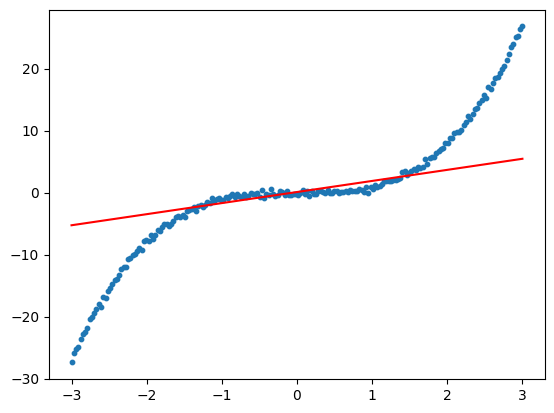

In [39]:
# tiny toy dataset
x = torch.linspace(-3.0, 3.0, 200).unsqueeze(1)
y = x**3 + 0.3 * torch.randn_like(x)


# minimal model
class EvidentialNet(nn.Module):
    def __init__(self) -> None:  # noqa: D107
        super().__init__()
        self.fc = nn.Linear(1, 4)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, ...]:  # noqa: D102
        out = self.fc(x)
        gamma = out[:, 0:1]
        v = F.softplus(out[:, 1:2])
        alpha = F.softplus(out[:, 2:3]) + 1.0
        beta = F.softplus(out[:, 3:4])
        return gamma, v, alpha, beta


model = EvidentialNet()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


# short training loop
for _ in range(1500):
    opt.zero_grad()
    gamma, v, alpha, beta = model(x)
    loss = evidential_loss(y, gamma, v, alpha, beta, lam=1e-2)
    loss.backward()
    opt.step()


# visualize result
with torch.no_grad():
    preds = model(x)[0]

plt.scatter(x, y, s=10)
plt.plot(x, preds, color="red")
plt.show()

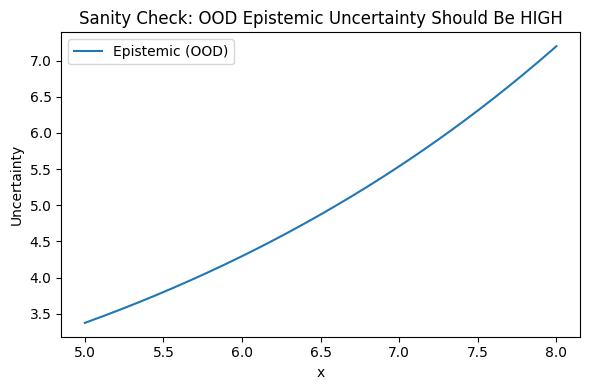

In [40]:
# Sanity Check: OOD epistemic uncertainty
import matplotlib.pyplot as plt
import torch

# OOD input range far from training domain
ood_x: torch.Tensor = torch.linspace(5.0, 8.0, 200).unsqueeze(1)

# Predict evidential parameters (model must already be trained)
with torch.no_grad():
    gamma_ood, v_ood, a_ood, b_ood = model(ood_x)

# Epistemic uncertainty: sqrt(beta / (v * (alpha - 1)))
epistemic_ood: torch.Tensor = (b_ood / (v_ood * (a_ood - 1.0))).sqrt()

# Plot epistemic uncertainty curve
plt.figure(figsize=(6, 4))
plt.plot(ood_x.squeeze(), epistemic_ood.squeeze(), label="Epistemic (OOD)")
plt.xlabel("x")
plt.ylabel("Uncertainty")
plt.title("Sanity Check: OOD Epistemic Uncertainty Should Be HIGH")
plt.legend()
plt.tight_layout()
plt.show()

### Application of the Unified Evidential Function 
In this segment, we will be using the unified evidential function created for classifiction and regression models alike, which will significantly reduce the length of the code and make it more practical.

In [41]:
# test with the unified function
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms


class MNIST1DRegression(Dataset):
    def __init__(self, mnist_dataset: Dataset) -> None:  # noqa: D107
        self.mnist = mnist_dataset

    def __len__(self) -> int:  # noqa: D105
        return len(self.mnist)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:  # noqa: D105
        x, y = self.mnist[idx]

        # 1D input
        x_1d = x.mean().view(1)

        # convert int -> tensor
        y = torch.tensor(y, dtype=torch.float32)

        # regression target
        y_reg = y / 9.0

        return x_1d, y_reg.view(1)


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ],
)


# In-distribution data
train_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=True,
    download=True,
    transform=transform,
)

test_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

train_data = MNIST1DRegression(train_data)
test_data = MNIST1DRegression(test_data)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

print("MNIST loaded (ID).")

# Out-of-distribution data
ood_data = torchvision.datasets.FashionMNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

ood_data = MNIST1DRegression(ood_data)

ood_loader = DataLoader(ood_data, batch_size=256, shuffle=False)

print(f"Loaded datasets with {len(train_data)} samples.")

MNIST loaded (ID).
Loaded datasets with 60000 samples.


In [42]:
from probly.models.evidential.torch import EvidentialRegressionModel
from probly.losses.evidential.torch import der_loss
from probly.train.evidential.torch import unified_evidential_train

loss = der_loss
model = EvidentialRegressionModel()
unified_evidential_train(mode="DER", model=model, dataloader=ood_loader, loss_fn=loss)

Epoch [1/5] - Loss: 0.9332
Epoch [2/5] - Loss: 0.4316
Epoch [3/5] - Loss: 0.3350
Epoch [4/5] - Loss: 0.3291
Epoch [5/5] - Loss: 0.3246


### 8. Project Insights 

Amini et al. (2020) provide the theoretical and practical foundation for evidential regression in probly. Their NIG-based uncertainty model, loss function, and evidence regularizer are exactly what our project needs to use to implement fast, sampling-free uncertainty estimation for continuous outputs.

### 9. Summary

Deep Evidential Regression gives neural networks a way to predict both a value and how certain they are about it. By predicting the parameters of a Normal-Inverse-Gamma distribution, the model learns aleatoric and epistemic uncertainty in a single forward pass. The combination of the Student-T likelihood and the evidence regularizer ensures that the model becomes confident only when it should. Overall, this method provides a simple and efficient way to add uncertainty estimation to regression models without relying on sampling or ensembles.